In [110]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn import metrics

from typing import *
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import math 
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution
from torch.distributions import Bernoulli, Normal
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.autograd import Variable
from tqdm import tqdm

from plotting import make_vae_plots

CMNIST_list = torch.load("data/ColoredMNIST/train1.pt")
CMNIST = pd.DataFrame(CMNIST_list, columns = ["image", "label"])

images = CMNIST.iloc[:,0]
labels_df = CMNIST.iloc[:,1]
labels = torch.tensor(labels_df)

In [111]:
from torchvision.transforms import ToTensor

transform_to_tensor = ToTensor()
transform_to_tensor(images[0]).shape

torch.Size([3, 28, 28])

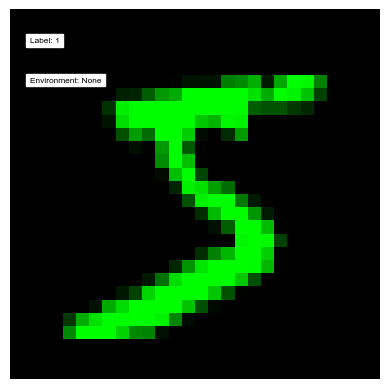

In [112]:
def show_CMNIST(image, label, environment):
    """Show image with landmarks"""
    plt.figure
    plt.imshow(image)
    plt.text(1,2,"Label: {}".format(label), backgroundcolor = "white",
             color = "black", fontsize = 6)
    plt.text(1,5,"Environment: {}".format(environment), backgroundcolor = "white",
             color = "black", fontsize = 6)
    plt.axis('off')
    plt.show
    plt.pause(0.001)  # pause a bit so that plots are updated

show_CMNIST(images[0], labels[0], None)

In [113]:
class CMNISTDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, pt_file, environment=None, transform=None):
        """
        Args:
            pt_file (string): Path to the pt file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            environment (integer): Integer indicating the environment the data comes from
        """
        self.CMNIST_frame = pd.DataFrame(torch.load(pt_file))
        self.transform = transform
        self.environment = environment

    def __len__(self):
        return len(self.CMNIST_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.CMNIST_frame.iloc[idx, 0]
        label = self.CMNIST_frame.iloc[idx, 1]
        sample = {'image': image, 'label': label, "environment": self.environment}

        if self.transform:
            sample = {'image': self.transform(image), 'label': label, "environment": self.environment}

        return sample

In [114]:
cmnist_data1 = CMNISTDataset(pt_file = "data/ColoredMNIST/train1.pt"
                            , environment = 1
                            , transform = transform_to_tensor)
cmnist_data2 = CMNISTDataset(pt_file = "data/ColoredMNIST/train2.pt"
                            , environment = 2
                            , transform = transform_to_tensor)
train_loader = DataLoader(ConcatDataset([cmnist_data1, cmnist_data2]), batch_size=256, num_workers=0, drop_last = True)

cmnist_test_data = CMNISTDataset(pt_file = "data/ColoredMNIST/test.pt"
                                 , environment = 3
                                 , transform = transform_to_tensor)
test_loader = DataLoader(cmnist_test_data, batch_size = 512, num_workers = 0, drop_last = True)

0 torch.Size([256, 3, 28, 28]) torch.Size([256])
1 torch.Size([256, 3, 28, 28]) torch.Size([256])
2 torch.Size([256, 3, 28, 28]) torch.Size([256])
3 torch.Size([256, 3, 28, 28]) torch.Size([256])


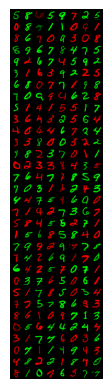

In [115]:
def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [116]:
p = Bernoulli(logits=torch.zeros((1000,)))


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    #def sample_epsilon(self) -> Tensor:
    #    """`\eps ~ N(0, I)`"""
    #    return torch.empty_like(self.mu).normal_()
        
    #def sample(self) -> Tensor:
    #    """sample `z ~ N(z | mu, sigma)` (without gradients)"""
    #    with torch.no_grad():
    #        return self.rsample()
        
    #def rsample(self) -> Tensor:
    #    """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
    #    self.z = torch.distributions.Normal(self.mu, self.sigma)
    #    return self.z.rsample() # <- your code
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        eps = torch.empty_like(self.mu).normal_()
        return self.mu + self.sigma * eps
    # <- your code    
        #return self.mu + self.sigma * self.sample_epsilon() # <- your code    
    
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return - ((z - self.mu)**2)/(2*self.sigma**2) - torch.log(self.sigma) - math.log(math.sqrt(2 * math.pi)) # <- your code
    
    def mu(self):
        return(self.mu, self.sigma)
    #def log_prob(self, z:Tensor) -> Tensor:
    #    """return the log probability: log `p(z)`"""
    #    dummy = self.rsample()
    #    return self.z.log_prob(z) # <- your code

In [117]:
#plot a few CMNIST examples
# f, axarr = plt.subplots(4, 16, figsize=(16, 4))
# plt.show()
# Load a batch of images into memory
sample = next(iter(train_loader))
images = sample['image']
label = sample['label']
environment = sample['environment']

# for i, ax in enumerate(axarr.flat):
#     ax.imshow(images[i].permute(1,2,0))
#     ax.axis('off')
    
# plt.suptitle('MNIST handwritten digits')
# plt.show()

In [118]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class iVAE(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(iVAE, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features

        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        ## setting the prior to a vector consisting of zeros with dimensions (1,2*latent_features)
        # self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
        '''
        According to page 31-32 the iVAE consist of 7 NNs:
        1. TNN prior
        2. lambdaNN prior
        3. lambdaf prior
        
        4. X-encoder (Classic image CNN)
        5. (Y, E)-encoder
        6. (X, Y, E)-merger/encoder

        7. Decoder

        1-3: Learn priors based on the label distribution for the given environment
        4-6: Encoding X, encoding Y and E and merging these two encoders, to generate a 
             qz which is conditional on the environment.
        7: Decodes the latent space through pz. Since the latent space now contain some measure
           of environment, then this distribution pz is consequentially conditioned on the environment

        NN 1-3 can be found in the variational inference funktion.
        '''
        #### PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS ####
        #NN 1/7
        self.TNN_prior = nn.Sequential(
            nn.Linear(in_features = latent_features, out_features=50), #Input
            # nn.Linear(in_features = 50, out_features=50), #Fully connected
            nn.ReLU(),
            nn.Linear(in_features = 50, out_features = 45)) #Output

        #NN 2/7
        self.LambdaNN_prior = nn.Sequential(
            nn.Linear(in_features = 2, out_features=50), #Input
            # nn.Linear(in_features = 50, out_features=50), #Fully connected
            nn.ReLU(),
            nn.Linear(in_features = 50, out_features = 45)) #Output

        #NN 3/7
        self.Lambdaf_prior = nn.Sequential(
            nn.Linear(in_features = 2, out_features=50), #Input
            # nn.Linear(in_features = 50, out_features=50), #Fully connected
            nn.ReLU(),
            nn.Linear(in_features = 50, out_features = 20))  #Output
        #### PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS ####

         #For NN 4/7 X-Encoder: Inference Network
         #Encode the observation `x` into the parameters of the posterior distribution
         #`q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoderCNN1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
        self.encoderCNN2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
        self.encoderCNN3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        ##NN 5/7 (Y, E)-Encoder
        self.YEencoder = nn.Sequential(
            nn.Linear(in_features = 2, out_features=100),
            # nn.Linear(in_features = 100, out_features = 100),
            nn.ReLU())

        ##NN 6/7 (X, Y, E)-merger/encoder
        #remember to concatenate x.flatten, y, e before running this.
        self.XYEmerger = nn.Sequential(
            nn.Linear(in_features = 32 * 4 * 4 + 100, out_features=100),
            # nn.Linear(in_features = 100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features = 100, out_features = 2*latent_features))


        #For NN 7/7 (Decoder): Generative Model
        #Decode the latent sample `z` into the parameters of the observation model
        #`p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoderFFN = nn.Linear(in_features=latent_features, out_features = 32 * 4 * 4)
        self.decoderFFN2 = nn.Linear(in_features = 32 * 4 * 4, out_features = 32 * 4 * 4)
        
        self.decoderCNN1 = nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1
                              ,output_padding = 0)
        self.decoderCNN2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1
                              ,output_padding = 1)
        self.decoderCNN3 = nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 3, stride = 2, padding = 1
                              ,output_padding = 1)

    #Non-factorized prior for NF-iVAE from page 28
    def non_factorized_prior_pz(self, z, TNN_parameters, lambdaNN_parameters, lambdaf_parameters, reduce = True):
        #beregning fra side 28 under M.2. P_T,lambda(Z|Y,E).
        z_cat = torch.cat((z, z.pow(2)), dim = 1) 
        # "(*).sum(dim=1)" is the vector-vector dot product. It is not possible to make this calculation with e.g. torch.tensordot, as we want the dot product of each vector and not the entire batch
        non_factorized_prior = (TNN_parameters*lambdaNN_parameters).sum(dim = 1) + (z_cat * lambdaf_parameters).sum(dim = 1)
        #the f,z term - (z_cat * lambdaf_parameters).sum(dim = 1): Is equivalent to the factorized exponential family
        #the NN term - (TNN_parameters*lambdaNN_parameters).sum(dim = 1): Capture the dependencies between the latent variables
        return non_factorized_prior

    def parameters_for_non_factorized_prior(self, z, y, e):
        """return the distribution `p(z)`"""
        TNN_parameters = self.TNN_prior(z)
        ye = torch.cat((y, e), dim = 1)
        ye = ye.to(torch.float32)
        LambdaNN_parameters = self.LambdaNN_prior(ye)
        lambdaf_parameters = self.Lambdaf_prior(ye)

        return TNN_parameters, LambdaNN_parameters, lambdaf_parameters

    #NN 4/7
    def encoder(self, x, y, e):
        x = self.relu(self.encoderCNN1(x))
        x = self.relu(self.encoderCNN2(x))
        x = self.relu(self.encoderCNN3(x))
        x = x.view(x.size(0), -1) #NN 4/7

        ye = torch.cat((y, e), dim = 1)
        ye = ye.to(torch.float32)
        ye = self.YEencoder(ye) #NN 5/7

        xye = torch.cat((x,ye), dim = 1)
        xye = self.XYEmerger(xye) #NN 6/7
    
        return xye
   
    #NN 7/7
    def decoder(self, z):
        
        x = self.relu(self.decoderFFN(z))
        # x = self.relu(self.decoderFFN2(x))
        
        # reshape x and add CNN decoder
        x = x.view(-1, 32, 4, 4)
        
        x = self.relu(self.decoderCNN1(x))
        x = self.relu(self.decoderCNN2(x))
        # x = self.decoderCNN3(x)
        x = self.sigmoid(self.decoderCNN3(x))
        return x
        
    def posterior(self, x:Tensor, y:Tensor, e:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x, y, e)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_loc = self.decoder(z)
        px_loc = px_loc.view(-1, *self.input_shape) # reshape the output #old
        #sandsynlighedsfordeling der giver 1 eller 0, baseret på log-odds givet i logits input fra p(x|z).
        #Dvs. at px_logits angiver sandsynligheden for at det givne pixel er henholdsvist rød,grøn,blå. Pixel værdien
        #er enten 0 eller 1. Når man sampler fra bernoulli fordelingen fås dermed et billede, som givet z, giver en figur,
        #som er bestemt af de sandsynligheder der er i px_logits (p(x|z)). Dvs. at for et givet latents space, kan en
        #figur/et tal reproduceres ud fra de beregnede sandsynligheder og den efterfølgende sample fra Bernoulli fordelingen.
        #return Bernoulli(logits=px_loc, validate_args=False)
        return Normal(loc=px_loc, scale = 0.1*torch.ones(px_loc.shape))
        

    def forward(self, x, y, e) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        #### Run through ENCODER and calculate mu and sigma for latent space sampling
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x, y, e)
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        #### LATENT SPACE
        z = qz.rsample()
        
        #### DECODER
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'qz': qz, 'z': z}

    def reduce(self, x:Tensor) -> Tensor:
        """for each datapoint: sum over all dimensions"""
        return x.view(x.size(0), -1).sum(dim=1)

    def VariationalInference(self, x, y, e):
        
        # forward pass through the model to get the encoder and decoder outputs
        parameters_and_latent_space = self.forward(x, y, e)

        # unpack encoder parameters from (px), decoder parameters (qz) and the latent space (z)
        px_ze, qz_xye, z = [parameters_and_latent_space[k] for k in ["px", "qz", "z"]]


        # DEFINE THE PRIOR p(z)
        #### PRIOR
        z_temp = z.detach().requires_grad_(requires_grad = True)
        y_temp = y.detach()
        e_temp = e.detach()
        TNN_parameters, LambdaNN_parameters, lambdaf_parameters = self.parameters_for_non_factorized_prior(z_temp, y_temp, e_temp) #bruger temp da priors træning ikke skal påvirke encoder og decoder

        #prior calculation from page 28 (til differentiering ifm. eq. 64 skal dette ikke være logget, men når
        # elbo loss beregnes, skal man huske at tage log at denne værdi jvf. p. 28)

        #According to page 6. equation (8)-(10)
        TNN_parameters_hat = TNN_parameters.detach()
        LambdaNN_parameters_hat = LambdaNN_parameters.detach()
        lambdaf_parameters_hat = lambdaf_parameters.detach()

        log_pz_ye_ELBO =  self.non_factorized_prior_pz(z, TNN_parameters_hat, LambdaNN_parameters_hat, lambdaf_parameters_hat)
        log_pz_ye_SM = self.non_factorized_prior_pz(z_temp, TNN_parameters, LambdaNN_parameters, lambdaf_parameters) #phi_hat (or phi.detach()) from page. 6 is implemented implicitly/auto-
        #matically through the implementation of SM on page 28 eq. (64), where autograd of p_T,lambda is used instead of the conditional distribution q_phi(Z|X,Y,E), here phi
        #is evidently excluded from the gradient calculation.
        #OBS: HER SKAL DER IKKE ANVENDES LOG-PROBS AF PZ_YE JVF. SM DELEN AF EQ. (64) PÅ SIDE 28... eller hvad???
        dpdz_ye = torch.autograd.grad(log_pz_ye_SM.sum(), z_temp, create_graph = True, retain_graph=True)[0]

        #ddpz_ye = torch.autograd.grad(dpz_ye.mean(), z_temp, create_graph = True, retain_graph=True)[0] #changed sum() to mean()
        ddpdz_sq_ye = torch.autograd.grad(dpdz_ye.sum(), z_temp, create_graph = True, retain_graph=True)[0] #original

        #### SM loss SM loss SM loss SM loss SM loss SM loss SM loss SM loss ####
        #Calculation from page 28 equation 64
        SM = (ddpdz_sq_ye + 0.5 * dpdz_ye.pow(2)).sum(1)
        #### SM loss SM loss SM loss SM loss SM loss SM loss SM loss SM loss ####

        #### ELBO loss ELBO loss ELBO loss ELBO loss ELBO loss ELBO loss ELBO loss ####
        # evaluate log probabilities
        # Skal jvf. s. 32 ændres til at være en normal fordeling i stedet for en
        # bernoulli fordeling, og her skal mean være outputtet af decoderen og varians skal
        #blot sættes til at være 0.01
        
        log_px_ze = self.reduce(px_ze.log_prob(x)) #log(p(x|z)): Sandsynligheden for at observere vores input variabel x
        #givet vores latent space (tjekker modellens evne til at rekonstruere sig selv, ved at maximere sandsynlig-
        #heden for at observere inputtet selv, givet det konstruerede latent space.
        
        ####(old)log_pz = reduce(pz.log_prob(z)) #log(p(z)): 
        #log_pz_ye = torch.log(pz_ye)#Sandsynligheden for at observere vores latent space, givet at
        #latent space følger en standard-normal fordeling (Jo højere sandsynlighed jo bedre)
        
        log_qz_xye = self.reduce(qz_xye.log_prob(z)) #log(q(z|x)): Sandsynligheden for at generere netop dette latent space givet 
        #vores input billede x. Denne værdi skal helst være lav?
        
        # compute the ELBO: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        #########################################################################################################
        # Reconstruction loss: E_q [ log p(x|z) ]
        # Regularization term: \beta * D_KL(q(z|x) | p(z))` => Forsøger at tvinge fordelingen q(z|x) mod N(0,1)?
        #########################################################################################################
        
        kl = log_qz_xye - log_pz_ye_ELBO
        
        elbo = log_px_ze - kl
        ####
        
        # loss
        loss = -(elbo.mean() - SM.mean())
        #print("SM: {}. elbo: {} = log_px_ze: {} + log_pz_ye: {} - log_qz_xye: {}".format(SM.mean(), elbo.mean(),log_px_ze.mean(),pz_ye.mean(),log_qz_xye.mean()))

        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px_ze, 'kl': kl}
        
        outputs = parameters_and_latent_space
        return loss, diagnostics, outputs

    #def sample_from_prior(self, batch_size:int=100):
    #    """sample z~p(z) and return p(x|z)"""
    #    
    #   # Laver bare reconstruction baseret på latent space
    #    #Kan evt. fjernes. Anvendes bare til at vise hvor god modellen er til at generere data baseret på
    #    #latent space genererede data. Funktionen anvendes kun i make_vae_plots.
    #    
    #    # degine the prior p(z)
    #    pz = self.prior(batch_size=batch_size)
    #    
    #    # sample the prior 
    #    z = pz.rsample()
    #    
    #    # define the observation model p(x|z) = B(x | g(z))
    #    px = self.observation_model(z)
    #    
    #    return {'px': px, 'pz': pz, 'z': z}


latent_features = 10 #Husk at opdater denne parameter nede i 'initialization', hvis den skal bruges i VAE loopet også
batch_size = 256
ivae = iVAE(images[0].shape, latent_features)
print(ivae)

iVAE(
  (TNN_prior): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=45, bias=True)
  )
  (LambdaNN_prior): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=45, bias=True)
  )
  (Lambdaf_prior): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
  )
  (encoderCNN1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoderCNN2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoderCNN3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (YEencoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
  )
  (XYEmerger): Sequential(
    (0): Linear(in_features=612, out_features=100, bias=True)
  

In [119]:
sample = next(iter(train_loader))
images = sample['image']
label = sample['label'].reshape(-1,1)
environment = sample['environment'].reshape(-1,1)

x = images
y = label
e = environment

In [120]:
loss, diagnostics, outputs = ivae.VariationalInference(x, y, e)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =  24248.387, shape: []
elbo   | mean = -24246.898, shape: [256]
log_px | mean = -24260.340, shape: [256]
kl     | mean =    -13.440, shape: [256]


In [121]:
from torchvision.utils import make_grid
def show_CMNIST(image, label, environment, ax):
    """Show image with landmarks"""
    ax.figure
    ax.imshow(image.permute(1,2,0))
    ax.text(1,2,"Label: {}".format(label), backgroundcolor = "white",
             color = "black", fontsize = 8)
    ax.text(1,5,"Environment: {}".format(environment), backgroundcolor = "white",
             color = "black", fontsize = 8)
    ax.axis('off')

In [123]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 10 #Hyper parameter
ivae = iVAE(images[0].shape, latent_features)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(ivae.parameters(), lr=1e-4) #Hyper parameter, tilføj evt. weight_decay (L2 regularization)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

In [124]:
torch.manual_seed(1)
num_epochs = 20 #hyper parametre
#batch size hyper parameter can be changed in the dataloader in the beginning.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
ivae = ivae.to(device)
sample_counter = 0
# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    ivae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader: #tqdm
        sample_counter += 1
        
        x = sample['image']
        x = x.to(device)

        y = sample['label'].reshape(-1,1)
        y = y.to(device)

        e = sample['environment'].reshape(-1,1)
        e = e.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        optimizer.zero_grad()
        loss, diagnostics, outputs = ivae.VariationalInference(x, y, e)
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    px = outputs['px']
    samples = px.sample()

    fig, axes = plt.subplots(2,2)
    show_CMNIST(x[0], label=int(y[0]), environment=int(e[0]), ax = axes[0,0])
    show_CMNIST(samples[0], label=int(y[0]), environment=int(e[0]),  ax = axes[0,1])
    axes[1,0].plot(training_data['elbo'], label = "elbo")
    display(fig)
    clear_output(wait = True)


    #if (epoch+1)%(num_epochs*0.1) == 0:
        #print("epoch: {}: training loss: elbo = {}, kl = {}, log_px = {}, total loss = {}".format(epoch, training_data['elbo'][epoch-1], training_data['kl'][epoch-1], training_data['log_px'][epoch-1]), loss)
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    #make_vae_plots(ivae, x, y, outputs, training_data, validation_data)

KeyboardInterrupt: 

In [23]:
#Dummy code for the testing of the PC algorithm to ensure the model data is prepared in the right format
import numpy as np
import pandas as pd
import cdt
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.2.2/bin/Rscript' # this path should point to your own R implementation !
from cdt.causality.graph import PC
import networkx as nx
import matplotlib.pyplot as plt

cmnist = ConcatDataset([cmnist_data1, cmnist_data2])
loader = DataLoader(cmnist, batch_size = 40000, batch_sampler = None)

sample = next(iter(loader))

x = sample['image']
y = sample['label'].reshape(-1,1)
e = sample['environment'].reshape(-1,1)

ivae.eval()
output = ivae.forward(x, y, e)

z = output['z']

z_full = z
x_full = x
y_full = y
e_full = e

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [24]:
z_df = pd.DataFrame(z.detach())
y_df = pd.DataFrame(y.detach())
e_df = pd.DataFrame(e.detach())

df = z_df; df['Y'] = y_df; df['E'] = e_df

df.columns = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10', 'Y', 'E']
df.head()

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Y,E
0,0.188484,0.073406,0.434233,-0.027588,1.452754,0.239418,1.525117,-0.571584,-1.506738,-0.968669,1,1
1,-0.162532,0.043471,1.690963,-0.006065,2.517773,0.032000,0.810136,0.095100,-1.473015,0.619443,0,1
2,-0.506173,0.738039,0.276469,-0.806862,0.167957,-1.283794,0.043776,0.467960,1.017432,0.512943,0,1
3,1.010641,-0.076282,-1.051958,0.378185,-1.830352,-2.021556,-0.324926,0.215460,0.688028,-0.508657,0,1
4,0.723845,0.103787,0.878589,1.168501,1.164111,-1.362798,-0.147078,-1.133726,0.156136,-0.914088,1,1


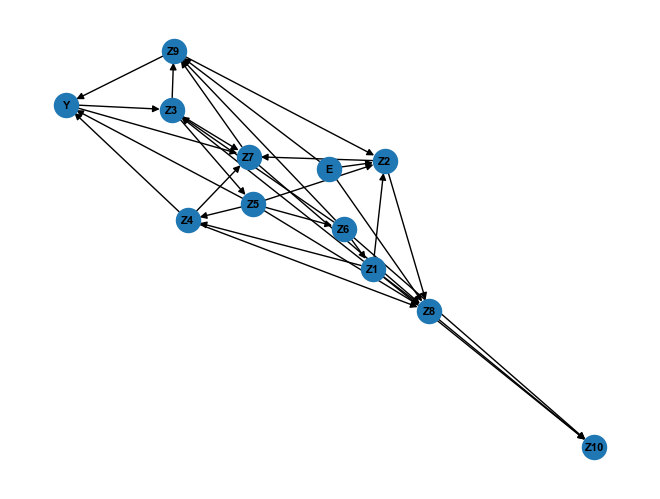

In [26]:
pc = PC(alpha=0.1)
pc_output = pc.predict(df)

nx.draw(pc_output, with_labels=True, font_weight='bold', font_size = 8)
plt.show()

In [27]:
def find_parents(pc_array,y_pos,z_pos):
    ind = np.where(pc_array[z_pos,y_pos] == 1)
    ind_DAGpar = []
    ind_par = []
    for i in ind[0]:
        if pc_array[y_pos,i] == 0:
            ind_DAGpar.append(i)
        else:
            ind_par.append(i)
    
    return ind_DAGpar, ind_par

In [28]:
pc_array = pc._run_pc(df)

DAGpar,par = find_parents(pc_array,10,range(0,10))

In [29]:
DAGpar

[3, 4, 8]

In [34]:
#Accuracy function from week 4:
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

#Building a classifier:

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        #Layers
        self.input_layer = nn.Linear(in_features=3, out_features = 50)
        self.layer1 = nn.Linear(in_features = 50, out_features = 100)
        self.output_layer = nn.Linear(in_features = 100, out_features = 1)

        #activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    #forward function(self, x):
    def forward(self, x):
        
        x = self.input_layer(x)
        x = self.relu(self.layer1(x))
        x = self.sigmoid(self.output_layer(x))

        return x
    # 

classifier = Classifier()
classifier.to(device)

Classifier(
  (input_layer): Linear(in_features=3, out_features=50, bias=True)
  (layer1): Linear(in_features=50, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [36]:
import torch.optim as optim
from sklearn import metrics

#Define loss function
loss_fn = nn.BCELoss() 
#The adam algorithm automatically use momentum
optimizer = optim.Adam(classifier.parameters(), lr = 1e-4) 

#Test model
out = classifier(z[1,DAGpar])
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")

Output shape: torch.Size([1])
Output logits:
[0.5417317]


>> Using device: cpu
Epoch  1 : , Train acc 0.846730, Valid acc 0.116837
Epoch  2 : , Train acc 0.848483, Valid acc 0.113131
Epoch  3 : , Train acc 0.848983, Valid acc 0.109926
Epoch  4 : , Train acc 0.849134, Valid acc 0.108423
Epoch  5 : , Train acc 0.848833, Valid acc 0.107322
Epoch  6 : , Train acc 0.849134, Valid acc 0.106520
Epoch  7 : , Train acc 0.848883, Valid acc 0.106671
Epoch  8 : , Train acc 0.848983, Valid acc 0.106020
Epoch  9 : , Train acc 0.849033, Valid acc 0.105970
Epoch 10 : , Train acc 0.849184, Valid acc 0.106070
Epoch 11 : , Train acc 0.848983, Valid acc 0.106070
Epoch 12 : , Train acc 0.849134, Valid acc 0.106170
Epoch 13 : , Train acc 0.849109, Valid acc 0.105919
Epoch 14 : , Train acc 0.849033, Valid acc 0.106520
Epoch 15 : , Train acc 0.849109, Valid acc 0.106220
Epoch 16 : , Train acc 0.849134, Valid acc 0.106320
Epoch 17 : , Train acc 0.849109, Valid acc 0.106370
Epoch 18 : , Train acc 0.849008, Valid acc 0.106220
Epoch 19 : , Train acc 0.849434, Valid acc 

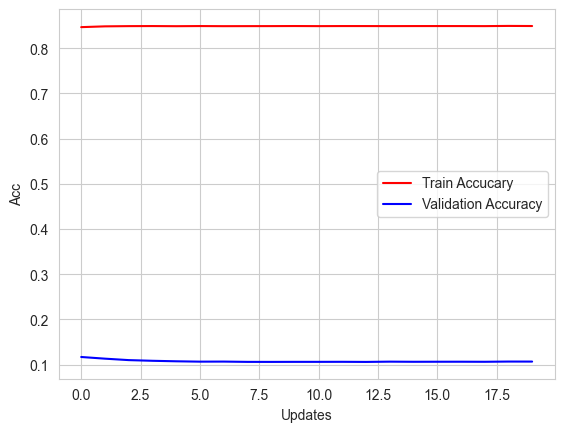

In [109]:
#TRAINING THE CLASSIFIER
epoch = 0
num_epochs = 20 #hyper parametre
#batch size hyper parameter can be changed in the dataloader in the beginning.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# training..
training_epoch_data = []
test_epoch_data = []
test_acc, train_acc = [], []

while epoch < num_epochs:
    epoch+= 1
    training_batch_data = []
    test_batch_data = []
    classifier.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader:
        x = sample['image']
        x = x.to(device)

        y = sample['label'].reshape(-1,1)
        y = y.to(device)

        e = sample['environment'].reshape(-1,1)
        e.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        with torch.no_grad():
           qz = ivae.posterior(x.float(), y.float(), e.float())
           z = qz.rsample()
           z = torch.index_select(z,1,torch.tensor([3,4,8]))

        #Get classification prediction
        output = classifier(z).view(-1)

        loss = loss_fn(output, y.reshape(len(y)).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current batch
        training_batch_data.append(loss)
            

    # gather data for the full epoch
    training_epoch_data.append(torch.tensor(training_batch_data).mean())

    # Evaluate on a single batch, do not propagate gradients
    # with torch.no_grad():
    #     classifier.eval()
        
    #     # Just load a single batch from the test loader
    #     sample = next(iter(test_loader))
    #     x = sample['image']
    #     y = sample['label'].to(torch.float32)
    #     x = x.to(device)
    #     y = y.to(device)
        
    #     # perform a forward pass through the model and compute the ELBO
    #     qz = vae.posterior(x)
    #     z = qz.rsample()
    #     output = classifier(z)
        
    #     # gather data for the validation step
    #     test_batch_data.append(loss)
    #     test_epoch_data.append(torch.tensor(training_batch_data).mean())
    #     print("Epoch: {}, Mean epoch loss: {}".format(epoch, torch.tensor(training_batch_data).mean()))

    #Evaluate training
    with torch.no_grad():
        classifier.eval()
        train_targs, train_preds = [], []
        for sample in train_loader:
            x = sample['image']
            x = x.to(device)

            y = sample['label'].reshape(-1,1)
            y = y.to(device)
            
            e = sample['environment'].reshape(-1,1)
            e.to(device)
        
            # perform a forward pass through the model and compute the ELBO
            with torch.no_grad():
                qz = ivae.posterior(x.float(), y.float(), e.float())
                z = qz.rsample()

            #Get classification prediction
            output = classifier(z[:,DAGpar]).view(-1)
            prediction = torch.round(output)

            train_targs += list(y[:,0].numpy())
            train_preds += list(prediction.data.numpy())

        #Evaluating validation
        val_targs, val_preds = [], []
        for sample in test_loader:
            x = sample['image']
            x = x.to(device)

            y = sample['label'].reshape(-1,1)
            y = y.to(device)
            
            # perform a forward pass through the model and compute the ELBO
            e = sample['environment'].reshape(-1,1)
            e.to(device)
        
            # perform a forward pass through the model and compute the ELBO
            with torch.no_grad():
                qz = ivae.posterior(x.float(), y.float(), e.float())
                z = qz.rsample()


            #Get classification prediction
            output = classifier(z[:,DAGpar]).view(-1)
            prediction = torch.round(output)

            val_targs += list(y[:,0].numpy())
            val_preds += list(prediction.data.numpy())

    train_acc_cur = accuracy(Tensor(train_targs),Tensor(train_preds))
    train_acc.append(train_acc_cur)

    test_acc_cur = accuracy(Tensor(val_targs),Tensor(val_preds))
    test_acc.append(test_acc_cur)
    print("Epoch %2i : , Train acc %f, Valid acc %f" % (
                epoch, train_acc_cur, test_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, test_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
plt.show()

In [103]:
output.shape

torch.Size([256])

In [108]:
y.reshape(len(y)).float()

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 